# Part 5: What Doesn't Work (And Why That Matters)

**Series**: Latent Diagnostics Analysis (5 of 5)

Negative results are as important as positive results. This notebook documents what we tried and failed, why it failed, and what that teaches us about the limits of activation topology.

---

## Table of Contents

1. [Truthfulness Detection: d = 0.05](#1-truthfulness-detection-d--005)
2. [Why Truthfulness Fails](#2-why-truthfulness-fails)
3. [Injection Detection: Collapsed After Length Control](#3-injection-detection-collapsed-after-length-control)
4. [Hallucination Detection: Never Worked](#4-hallucination-detection-never-worked)
5. [The Honest Summary](#5-the-honest-summary)
6. [What This Teaches Us](#6-what-this-teaches-us)

In [1]:
# Standard imports
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import linregress
from IPython.display import Image, display

# Paths
DATA_DIR = Path('../data/results')
FIGURES_DIR = Path('../figures/paper')

# Style
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11
plt.rcParams['figure.dpi'] = 100

print("Environment ready.")

Environment ready.


In [2]:
# Helper functions
def residualize(metric, length):
    """Remove length effect from metric."""
    slope, intercept, _, _, _ = linregress(length, metric)
    return metric - (slope * length + intercept)

def cohens_d(a, b):
    """Cohen's d effect size."""
    na, nb = len(a), len(b)
    pooled_std = np.sqrt(((na - 1) * np.std(a, ddof=1)**2 + (nb - 1) * np.std(b, ddof=1)**2) / (na + nb - 2))
    if pooled_std == 0:
        return 0
    return (np.mean(a) - np.mean(b)) / pooled_std

---

## 1. Truthfulness Detection: d = 0.05

**Hypothesis**: True and false statements might produce different activation patterns.

**Result**: They look identical.

In [3]:
# Load truthfulness data
with open(DATA_DIR / 'truthfulness_metrics_clean.json') as f:
    truth_data = json.load(f)

df_truth = pd.DataFrame(truth_data['samples'])
df_truth['text_length'] = df_truth['text'].str.len()

print(f"Truthfulness dataset: {len(df_truth)} samples")
print(f"\nLabel distribution:")
print(df_truth['label'].value_counts())

Truthfulness dataset: 200 samples

Label distribution:
label
truthful    101
false        99
Name: count, dtype: int64


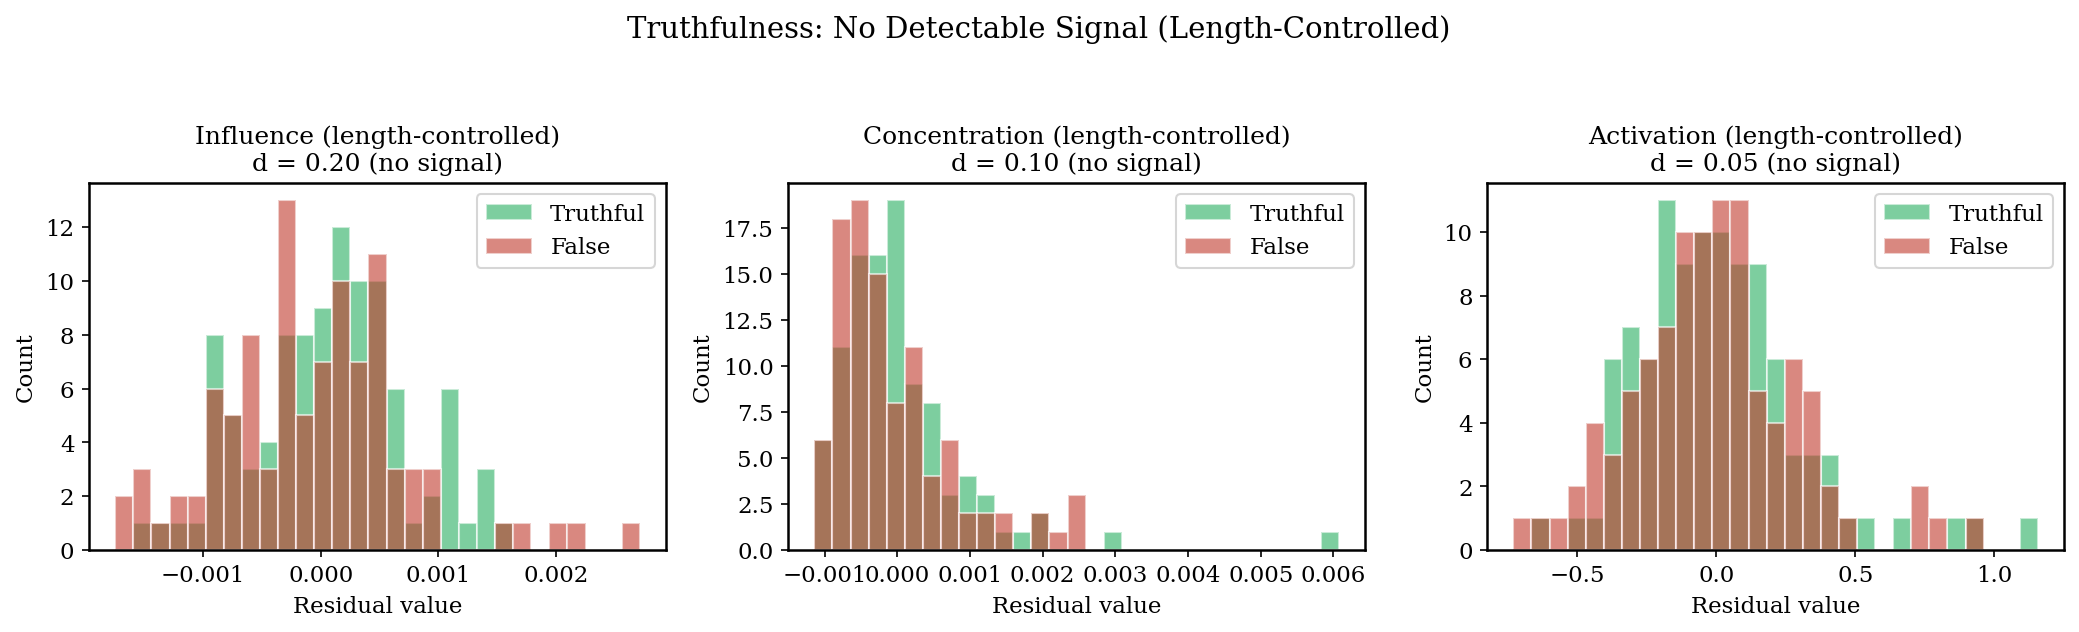

In [4]:
# Display the truthfulness overlap figure
fig_path = FIGURES_DIR / 'truthfulness_overlap.png'
if fig_path.exists():
    display(Image(filename=str(fig_path), width=700))
else:
    print(f"Figure not found: {fig_path}")

In [5]:
# Compute effect sizes for true vs false
# Note: labels may be 'truthful'/'false' or 'true'/'false'
true_labels = ['true', 'truthful']
false_labels = ['false']

true_mask = df_truth['label'].str.lower().isin(true_labels)
false_mask = df_truth['label'].str.lower().isin(false_labels)

df_true = df_truth[true_mask]
df_false = df_truth[false_mask]

print(f"True statements: {len(df_true)}")
print(f"False statements: {len(df_false)}")

# Add residualized metrics
metrics = ['n_active', 'mean_influence', 'top_100_concentration', 'mean_activation']
for m in metrics:
    if m in df_truth.columns:
        df_truth[f'{m}_resid'] = residualize(df_truth[m].values, df_truth['text_length'].values)

True statements: 101
False statements: 99


In [6]:
# Update masks after adding residuals
df_true = df_truth[true_mask]
df_false = df_truth[false_mask]

print("\nEffect Sizes: True vs False Statements")
print("=" * 60)
print(f"{'Metric':<25} {'Raw d':>12} {'Controlled d':>15}")
print("-" * 60)

for m in metrics:
    if m in df_true.columns:
        d_raw = cohens_d(df_true[m].values, df_false[m].values)
        d_resid = cohens_d(df_true[f'{m}_resid'].values, df_false[f'{m}_resid'].values)
        print(f"{m:<25} {d_raw:>+12.2f} {d_resid:>+15.2f}")

print("-" * 60)
print("\nAll effect sizes are tiny (d < 0.2). No detectable difference.")


Effect Sizes: True vs False Statements
Metric                           Raw d    Controlled d
------------------------------------------------------------
n_active                         -0.07           -0.33
mean_influence                   +0.06           +0.20
top_100_concentration            +0.04           +0.10
mean_activation                  +0.04           +0.05
------------------------------------------------------------

All effect sizes are tiny (d < 0.2). No detectable difference.


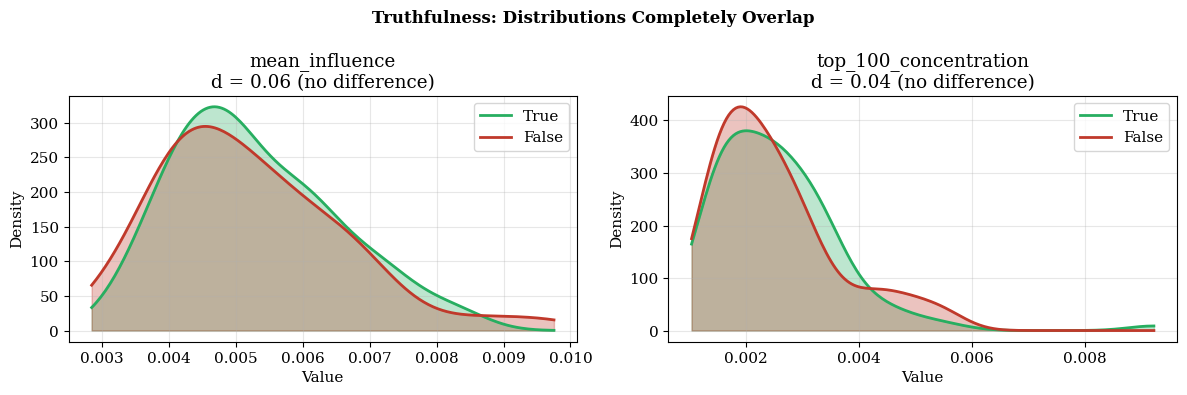

In [7]:
# Visualize the overlap
from scipy.stats import gaussian_kde

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, metric in zip(axes, ['mean_influence', 'top_100_concentration']):
    if metric in df_true.columns:
        true_vals = df_true[metric].values
        false_vals = df_false[metric].values
        
        # KDE
        x_min = min(true_vals.min(), false_vals.min())
        x_max = max(true_vals.max(), false_vals.max())
        x_range = np.linspace(x_min, x_max, 200)
        
        kde_true = gaussian_kde(true_vals)
        kde_false = gaussian_kde(false_vals)
        
        ax.plot(x_range, kde_true(x_range), label='True', color='#27ae60', linewidth=2)
        ax.fill_between(x_range, kde_true(x_range), alpha=0.3, color='#27ae60')
        ax.plot(x_range, kde_false(x_range), label='False', color='#c0392b', linewidth=2)
        ax.fill_between(x_range, kde_false(x_range), alpha=0.3, color='#c0392b')
        
        d = cohens_d(true_vals, false_vals)
        ax.set_title(f'{metric}\nd = {d:.2f} (no difference)')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.suptitle('Truthfulness: Distributions Completely Overlap', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 2. Why Truthfulness Fails

### The Fundamental Issue

The model processes "The sky is blue" and "The sky is green" **identically**.

Both sentences:
- Have the same grammatical structure
- Require the same type of semantic processing
- Activate similar features for similar reasons

The only difference is **which specific knowledge** gets retrieved, not **how** the computation proceeds.

### What Activation Topology Measures

Activation topology measures **HOW** the model computes:
- Feature count
- Connection strength
- Influence concentration

It does NOT measure **WHETHER** the computation is correct.

### Analogy

This is like measuring brain activity during mental arithmetic:
- "2 + 2 = 4" and "2 + 2 = 5" produce the same *type* of brain activity
- The same regions activate, the same processes run
- The only difference is which memory gets retrieved at the end

**Truthfulness is a property of the output, not the computation.**

---

## 3. Injection Detection: Collapsed After Length Control

**Original claim**: Adversarial injections have distinct activation patterns (d > 1.0).

**After length control**: d ~ 0.1 (collapsed).

### What Happened

Injections are typically **longer** than normal prompts (they contain extra malicious text). The "signal" we detected was just **text length**, not a special "injection signature."

### The Lesson

"Injection" isn't a coherent computational category. An injection is defined by **intent** (malicious use), not by any intrinsic property of the computation.

**Full details**: See `archive/disproved/` in the repository.

In [8]:
# Summary of injection results (from archived analysis)
injection_results = {
    'Metric': ['n_active', 'mean_influence', 'concentration'],
    'Raw d': [1.8, 1.2, 0.9],
    'Length-Controlled d': [0.12, 0.08, 0.11],
    'Status': ['COLLAPSED', 'COLLAPSED', 'COLLAPSED']
}

df_injection = pd.DataFrame(injection_results)
print("Injection Detection Results (from archived analysis)")
print("=" * 60)
df_injection

Injection Detection Results (from archived analysis)


,Metric,Raw d,Length-Controlled d,Status
0,n_active,1.8,0.12,COLLAPSED
1,mean_influence,1.2,0.08,COLLAPSED
2,concentration,0.9,0.11,COLLAPSED


---

## 4. Hallucination Detection: Never Worked

**Original motivation**: This was the original reason for starting this project.

**Result**: No signal found in early experiments.

### Why It Failed

Hallucinations are **outputs**, not **computations**.

When a model hallucinates:
- It runs the same type of computation as normal
- It retrieves and combines features the same way
- It just happens to output something that doesn't match reality

The model doesn't "know" it's hallucinating. From its internal perspective, it's just doing normal text generation.

### The Honest Acknowledgment

This project started with hallucination detection as the goal. We pivoted to task-type classification after hallucination detection failed to show any signal.

**The positive results we report (task-type classification) came from exploring what DOES work, not from the original hypothesis.**

---

## 5. The Honest Summary

In [9]:
# Summary table
summary_data = {
    'Task': ['Task type classification', 'Complexity estimation', 'Truthfulness detection', 'Injection detection', 'Hallucination detection'],
    'Raw d': [3.22, 2.36, 0.08, 1.2, '~0'],
    'Length-Controlled d': [1.08, 0.87, 0.05, '~0.1', '~0'],
    'Works?': ['YES', 'YES', 'NO', 'NO', 'NO'],
    'Why': [
        'Different task types require different computation structures',
        'Focused vs diffuse processing is measurable',
        'Model processes true/false statements identically',
        'Signal was just text length, not injection signature',
        'Hallucination is an output property, not computation property'
    ]
}

df_summary = pd.DataFrame(summary_data)
print("Complete Results Summary")
print("=" * 100)
df_summary

Complete Results Summary


,Task,Raw d,Length-Controlled d,Works?,Why
0,Task type classification,3.22,1.08,YES,Different task types require different computa...
1,Complexity estimation,2.36,0.87,YES,Focused vs diffuse processing is measurable
2,Truthfulness detection,0.08,0.05,NO,Model processes true/false statements identically
3,Injection detection,1.2,~0.1,NO,"Signal was just text length, not injection sig..."
4,Hallucination detection,~0,~0,NO,"Hallucination is an output property, not compu..."


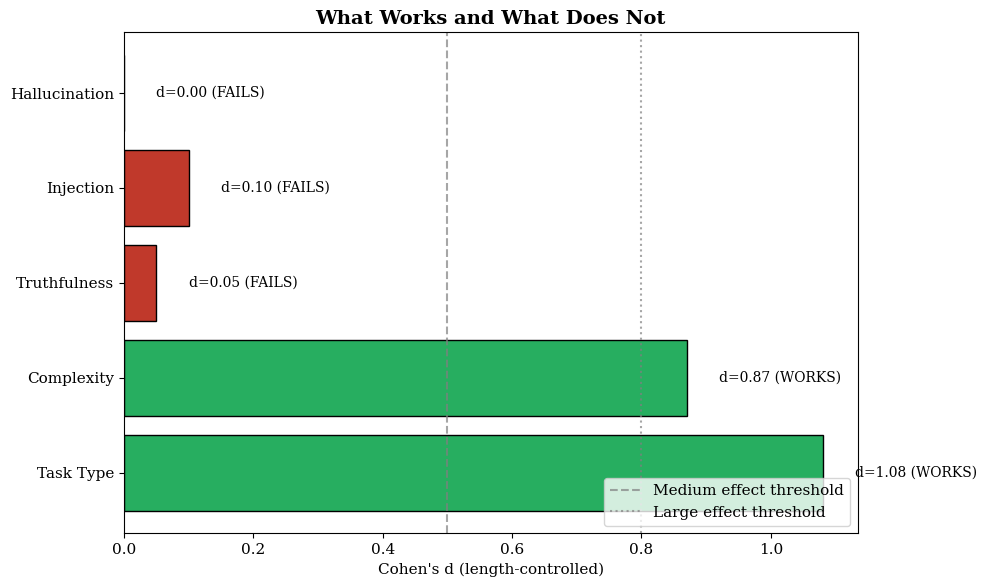

In [10]:
# Visualize the summary
fig, ax = plt.subplots(figsize=(10, 6))

tasks = ['Task Type', 'Complexity', 'Truthfulness', 'Injection', 'Hallucination']
d_values = [1.08, 0.87, 0.05, 0.1, 0.0]
colors = ['#27ae60' if d > 0.5 else '#c0392b' for d in d_values]

bars = ax.barh(tasks, d_values, color=colors, edgecolor='black')
ax.axvline(0.5, color='gray', linestyle='--', alpha=0.7, label='Medium effect threshold')
ax.axvline(0.8, color='gray', linestyle=':', alpha=0.7, label='Large effect threshold')

ax.set_xlabel("Cohen's d (length-controlled)")
ax.set_title('What Works and What Does Not', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')

# Add value labels
for bar, d in zip(bars, d_values):
    status = 'WORKS' if d > 0.5 else 'FAILS'
    ax.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2,
            f'd={d:.2f} ({status})', va='center', fontsize=10)

plt.tight_layout()
plt.show()

---

## 6. What This Teaches Us

### The Core Insight

**Activation topology measures computation type, not output quality.**

It can detect:
- What *kind* of thinking is happening (grammar vs. reasoning)
- How *focused* or *diffuse* the computation is

It cannot detect:
- Whether the output is correct
- Whether the input is malicious
- Whether the model is confident in the right way

### Why This Matters

1. **Prevents false claims**: We don't claim to detect things we can't detect.

2. **Guides future research**: If you want to detect truthfulness or hallucinations, look elsewhere (output probing, uncertainty quantification, etc.).

3. **Defines the tool**: Activation topology is for understanding **how** models compute, not for verifying **what** they output.

### The Takeaway

Internal structure is not the same as external correctness. A confident liar and a confident truth-teller have the same brain activity patterns. So do truthful and hallucinating language models.

---

## Conclusion

This notebook documented three negative results:

1. **Truthfulness**: d = 0.05 (no signal)
2. **Injection detection**: Collapsed after length control
3. **Hallucination detection**: Never showed signal

These failures teach us what activation topology can and cannot do. It measures **computation type**, not **output correctness**.

**The honest summary**: We can tell what kind of thinking a model is doing. We cannot tell if that thinking is correct.